# 04wk-1: 로지스틱 – 로지스틱의 한계 극복

최규빈  
2025-03-26

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/04wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-zH5ftAQumLjMjKH69uq1B2&si=Pxq4dj0iWcY1zkM0 >}}

# 2. Imports

In [3]:
import torch
import matplotlib.pyplot as plt 
import pandas as pd

In [5]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

In [8]:
# 오늘의 잔소리.. 
## 회귀: linr(x), 정규분포, MSEloss, yhat = 직선, 카페예제
## 로지스틱: sig(linr(x)), 베르누이, BCELoss, yhat = 곡선 = sig(직선), 취업예제 
## 이름없음: , s, yhat=꺽이는곡선=sig(꺽인직선), 취업예제2 

# 3. 꺽인그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺽인
그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 ${\bf x}$를 가정하자.

In [83]:
x = torch.linspace(-1,1,1001).reshape(-1,1)
x

`-` 목표: 아래와 같은 벡터 ${\bf y}$를 만들어보자.

$${\bf y} = [y_1,y_2,\dots,y_{n}]^\top, \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

> **Caution**
>
> 여기에서 $({\bf x},{\bf y})$ 는 (독립변수,종속변수) 혹은
> (설명변수,반응변수) 를 의미하는게 아님.

`# 방법1` – 수식 그대로 구현

In [84]:
y = x*0 
y[x<0] = (9*x+4.5)[x<0]
y[x>0] = (-4.5*x+4.5)[x>0]

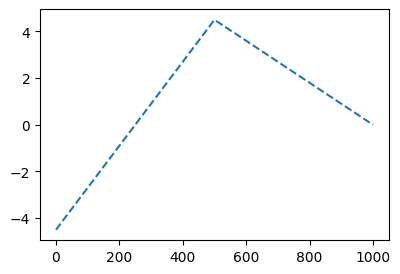

In [85]:
plt.plot(y,'--')

`#`

`# 방법2` – 렐루이용

In [86]:
relu = torch.nn.ReLU()

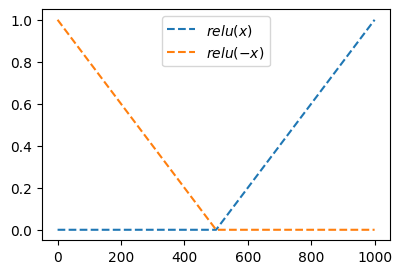

In [87]:
plt.plot(relu(x),'--',label=r'$relu(x)$')
plt.plot(relu(-x),'--',label=r'$relu(-x)$')
plt.legend()

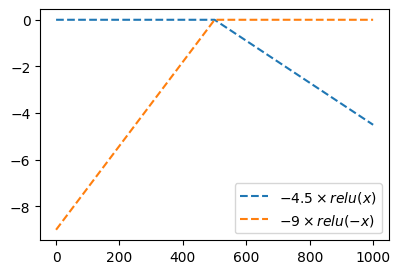

In [88]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.legend()

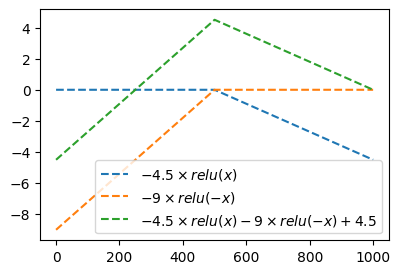

In [89]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)+4.5$')
plt.legend()

`-` 시각화

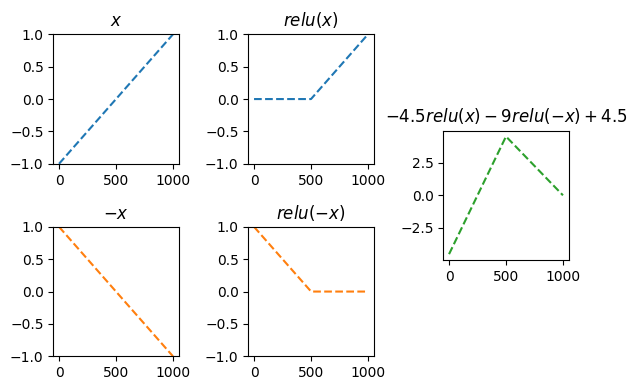

In [90]:
fig = plt.figure(figsize=(6, 4))
spec = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title(r'$x$'); ax1.set_ylim(-1,1)
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title(r'$-x$'); ax2.set_ylim(-1,1)
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title(r'$relu(x)$'); ax3.set_ylim(-1,1)
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title(r'$relu(-x)$'); ax4.set_ylim(-1,1)
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title(r'$-4.5 relu(x)-9 relu(-x)+4.5$')
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
fig.tight_layout()

`#`

`# 방법3` – 방법2의 다른구현!

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) + 9 \* relu(-x) +4.5 를 계산한다.

`-` 1단계

In [91]:
x,relu

`-` 2단계

In [92]:
u = torch.concat([x,-x],axis=1) # u = [x, -x] 같은것
u

`-` 3단계

In [93]:
v = relu(u) # 각각의 column에 렐루취함
v

`-` 4단계

In [94]:
-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

In [95]:
y

`#`

`# 방법4` – 방법3의 다른구현!

`-` 그런데, 방법3의 4단계는 아래와 같이 볼 수 있다.

In [96]:
# -4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

-   ${\bf v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix}
    v_{11} & v_{12}  \\
    v_{21} & v_{22}  \\
    \dots & \dots  \\
    v_{n1} & v_{n2}  \\
    \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 =
    \begin{bmatrix}
    -4.5 v_{11} - 9.0 v_{12} + 4.5  \\
    -4.5 v_{21} - 9.0 v_{22} + 4.5  \\
    \dots \\
    -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\
    \end{bmatrix}$

`-` 위의 수식을 참고하여 매트릭스의 곱 형태로 다시 포현하면 아래와 같다.

In [97]:
#-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5
What = torch.tensor([[-4.5],[-9.0]]) 
v @ What + 4.5 

`-` 이제 매트릭스의 곱 대신에 `torch.nn.Linear()`를 이용하면 아래의
코드와 같아진다.

In [98]:
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)

In [99]:
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [100]:
l2(v)

`-` 정리하면

In [101]:
u = torch.concat([x,-x],axis=1)
v = relu(u)
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])
l2(v)

`#`

`# 방법5` – 방법3의 또 다른 구현

`-` 사실 방법3의 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [102]:
#u = torch.concat([x,-x],axis=1) # u1 = [x, -x] 같은것

In [103]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])

In [104]:
l1(x)

`-` 따라서 `torch.nn` 에 포함된 레이어를 이용하면 아래와 같이 표현할 할
수 있다.

In [105]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [106]:
l2(a1(l1(x))), y

`#`

`# 방법6` – net를 이용

`-` 각각의 layer를 `torch.nn.Sequential()` 로 묶으면 아래와 같이 정리할
수 있다.

In [107]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [108]:
net(x),y

`#`

> **Note**
>
> ***수식표현***
>
> `(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$
>
> `(2)`
> $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$
>
> -   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
> -   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$
>
> `(3)`
> $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$
>
> `(4)`
> $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$
>
> -   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
> -   $b^{(2)}=4.5$
>
> `(5)`
> $net({\bf X})=(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

# 4. 취업데이터 다시 적합

`-` 다시한번 데이터 정리

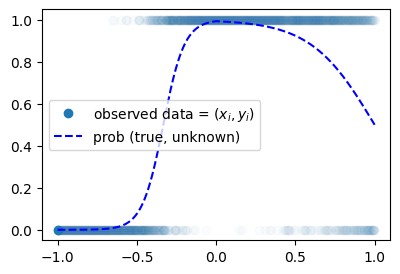

In [109]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` Step1-4

In [110]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

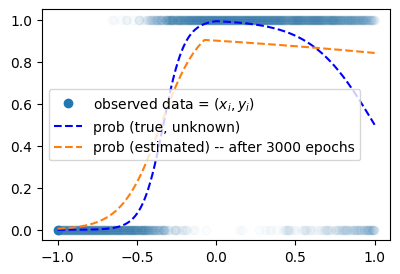

In [111]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 3000 epochs")
plt.legend()

In [112]:
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

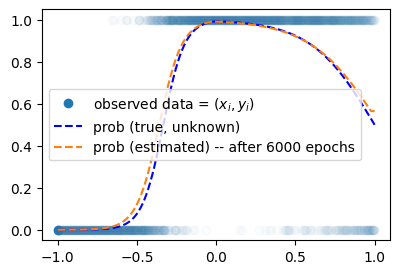

In [113]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 6000 epochs")
plt.legend()